In [1]:
import os
from typing import TypedDict, Annotated, Literal, List, Any
from dotenv import load_dotenv
from langchain.agents import create_agent
from langchain.agents.middleware import after_model
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolRuntime, ToolNode
from langgraph.types import Command, interrupt
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langgraph.runtime import Runtime
from langgraph.graph import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.stores import InMemoryStore
# from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import DuckDuckGoSearchRun
from pyasn1_modules.rfc2459 import CommonName
from pydantic import BaseModel, Field
from typing_extensions import runtime

In [25]:
class RLAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    user_input: str
    steps: str
    reasoning: str
    changes: list[str]
    first_response: str
    current_response: str
    final_response: str
    jump_to: str
    content: list[Any]
    insights: str
    first_run: bool
    counter: int
    max_loop: int

In [3]:
store = InMemoryStore()
user_id = '1'
namespace = (user_id, 'insights')

In [4]:
model = ChatGoogleGenerativeAI(
    model='gemini-2.5-flash',
    temperature=0.2,
    api_key=os.getenv('GOOGLE_API_KEY')
)

In [5]:
search = DuckDuckGoSearchRun()
# search.invoke("Obama's first name?")

In [6]:
tools = [search]

In [7]:
search_agent = create_agent(model=model, tools=tools, state_schema=RLAgentState)

In [8]:
model_with_tools = model.bind_tools(tools)

In [9]:
class Reasoning(BaseModel):
    steps: str = Field(description='All the planned steps in order', min_length=1)
    reasoning: str = Field(description='Reasoning for every planning step in order', min_length=1)

class Research(BaseModel):
    target_age_group: Literal['18 and below','18-45','45 and above']
    target_gender: Literal['Male','Female', 'Non-Binary']
    target_demographic: str = Field(description='Category based on interests', min_length=1)

In [10]:
reasoning_prompt = ChatPromptTemplate.from_template(
    """
    You are given a user input {input}. Your job is to plan your steps and mention your reasoning behind your planning. You have these tools: {tools}
    """
)
reasoning_chain = reasoning_prompt | model.with_structured_output(Reasoning)

reasoning_with_insights_prompt = ChatPromptTemplate.from_template(
    """
    You are given a user input {input} and insights from previous runs {insights}. Your job is to plan your steps for tackling the query and mention your reasoning or thought process behind your planning for each step. You have these tools: {tools}
    """
)
reasoning_with_insights_chain = reasoning_with_insights_prompt | model.with_structured_output(Reasoning)

In [11]:
def search_browser(query : str | None, runtime: ToolRuntime[RLAgentState, None], tool_call_id: Annotated[str, InjectedToolCallId]) -> Command:
    """
    This tool calls another agent who search the web to fnd results
    :param query: str
    :param runtime: ToolRuntime[RLAgentState, None]
    :param tool_call_id: Annotated[str, InjectedToolCallId]
    :return: Command
    """
    messages = runtime.state['messages']


    res = search_agent.invoke({
        'messages': SystemMessage(content='You are an agent who can use search tools to fnd the most relevant texts based on the user queries from the web') + messages,
    })

    # res = search_agent.invoke({
    #     'messages': SystemMessage(content='You are an agent who can use search tools to fnd the most relevant texts based on the user queries from the web') + HumanMessage(content=query),
    # })

    return Command(update=
        {
            'messages': ToolMessage(content=res['messages'][-1], tool_call_id=tool_call_id)
        }
    )

def create_research(runtime: ToolRuntime[RLAgentState, None], tool_call_id: Annotated[str, InjectedToolCallId]) -> Command:
    """
    This tool calls another agent who creates a research based on all the gathered information from tools
    :param runtime: ToolRuntime[RLAgentState, None]
    :param tool_call_id: Annotated[str, InjectedToolCallId]
    :return: Command
    """
    messages = runtime.state['messages']

    system_message = SystemMessage(content='You are an agent that conducts research based on the provided details and responds in a structured way')

    res = model.with_structured_output(Research).invoke(
        {
            "messages": [{"role": "user", "content": [system_message]+messages}]
        }
    )
    out_message = f"""
    The Research conducted is as follows:
    The Target Age group is {res.target_age_group},
    The Target Gender is {res.target_gender},
    The Target Demographic who is interested is {res.target_demographic},
    """

    if runtime.state['first_run']:

        return Command(update=
            {
                'messages' : ToolMessage(content=out_message, tool_call_id=tool_call_id),
                'first_run': False,
                'first_response': out_message,
                'current_response': out_message,
                'content': [res.target_age_group,res.target_gender,res.target_demographic]
            }
        )

    else:
        return Command(update=
            {
                'messages' : ToolMessage(content=out_message, tool_call_id=tool_call_id),
                'current_response': res,
                'content': [res.target_age_group,res.target_gender,res.target_demographic]
            }
        )


In [29]:
tool_agents = [search_browser, create_research]

def planning_reasoning_step(state: RLAgentState):

    if state['first_run']:

        res = reasoning_chain.invoke(
            {
                'input' : state['user_input'],
                'tools' : tools,
            }
        )

        return {
            'messages' : AIMessage(content='The Plan is as follows : ' + res.steps + '\n\n' +
                                           'The reasoning for them is as follows : ' + res.reasoning),
            'reasoning' : res.reasoning,
            'steps': res.steps,
            'tools': tools,
        }

    else:

        res = reasoning_with_insights_chain.invoke(
            {
                'input' : state['user_input'],
                'insights': state['insights'],
                'tools' : tools,
            }
        )

        return {
            'messages' : AIMessage(),
            'reasoning' : res.reasoning,
            'steps' : res.steps,
        }


def router(state: RLAgentState):

    messages = state['messages']

    res = model.bind_tools(tool_agents).invoke(
        {
            'messages' : messages,
        }
    )

    return {
        'messages' : res
    }

def which_agent(state: RLAgentState)->Literal['search_agent','research_agent','Invalid',END]:

    last_message = state['messages'][-1]
    if len(last_message.tool_calls)>0:
        tool = last_message.tool_calls[0]['name']
        if tool == 'search_agent':
            return 'search_agent'
        elif tool == 'research_agent':
            return 'research_agent'
        else:
            return 'Invalid'

    else:
        return END

def hitl(state: RLAgentState, runtime: Runtime):

    output = [state['reasoning'], state['current_response'], state['content']]
    changes = interrupt(
        output
    )

    if changes == 'Approved':
        return {
            'messages': AIMessage(content='No changes needed. Proceed to Finalise Research'),
            'final_response': state['current_response'],
            'jump_to': 'END'
        }

    else:
        return {
            'messages': AIMessage(content='Changes added. Refer them to redo research'),
            'changes': state['changes'].append(changes),
            'jump_to': 'router'
        }

def is_approved(state: RLAgentState)->Literal[END,'router']:

    if state['jump_to'] == 'END':
        return END
    else:
        return 'router'

search_browser_node = ToolNode(name='search_agent', tools=[search_browser])
create_research_node = ToolNode(name='research_agent', tools=[create_research])

In [21]:
checkpointer = InMemorySaver()
config = {
    'configurable' : {
        'thread_id': '1'
    }
}

In [30]:
graph = StateGraph(RLAgentState)

graph.add_node('planning_reasoning', planning_reasoning_step)
graph.add_node('router', router)
graph.add_node('browser_search', search_browser)
graph.add_node('create_research', create_research)
graph.add_node('hitl', hitl)
graph.add_edge(START, 'planning_reasoning')
graph.add_edge('planning_reasoning', 'router')
graph.add_conditional_edges('router', which_agent, {
    'search_agent': 'browser_search',
    'research_agent':'create_research',
    END : END
})
graph.add_edge('browser_search', 'router')
graph.add_edge('create_research', 'hitl')
graph.add_conditional_edges('hitl', is_approved, {
    END: END,
    'router': 'router'
})

agent = graph.compile(checkpointer=checkpointer)

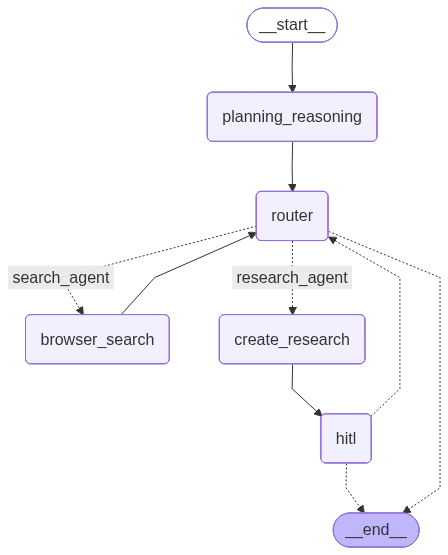

In [31]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())

In [ ]:
input = ''

In [ ]:
res = agent.invoke(
    {
        'messages': HumanMessage(content=input),
        'user_input': input,
        'insights': '',
        'first_run': True,
        'counter': 0,
        'max_loop': 2,
    }
)